In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [28]:
results = []
for results_file in Path(os.getcwd()+os.path.sep+'models_results').rglob('*.csv'):
    if 'training' in str(results_file):continue
    results_df = pd.read_csv(results_file)
    file_name = str(results_file).rsplit(os.path.sep)[-1].split('.')[0]
    results_df['model_name'] = file_name
    results.append(results_df)
    
models_performances = pd.concat(results)
print(len(models_performances))
models_performances.head()

4836


,base_name,noise,snr,accuracy,model_name
0,ch1_1462-170142-0017.gzip,white,18,98.611111,basic_rnn
1,ch1_251-137823-0025.gzip,pink,12,98.245614,basic_rnn
2,ch1_1462-170138-0022.gzip,office,18,97.668394,basic_rnn
3,ch1_1462-170138-0022.gzip,office,12,97.668394,basic_rnn
4,ch1_1462-170138-0022.gzip,white,18,97.409326,basic_rnn


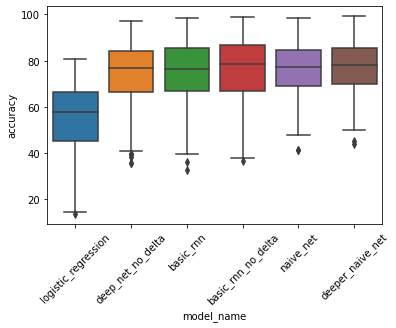

In [52]:
#so how is the best model?
order = models_performances.groupby(by=["model_name"])["accuracy"].mean().sort_values().index
p = sns.boxplot(x="model_name", y="accuracy",
            data=models_performances
            , order=order)
for label in p.get_xticklabels():
    label.set_rotation(45)

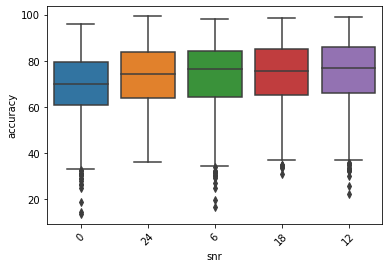

In [53]:
# sainety cheak - are we doing better the higher the snr is?
order = models_performances.groupby(by=["snr"])["accuracy"].mean().sort_values().index
p = sns.boxplot(x="snr", y="accuracy",
            data=models_performances
            , order=order)
for label in p.get_xticklabels():
    label.set_rotation(45)

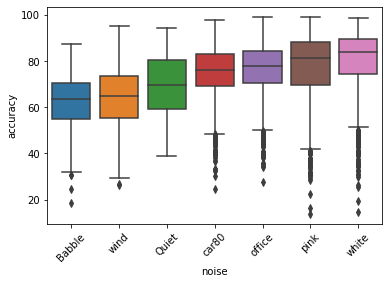

In [54]:
# which noise type is the hardest to get?
order = models_performances.groupby(by=["noise"])["accuracy"].mean().sort_values().index
p = sns.boxplot(x="noise", y="accuracy",
            data=models_performances
                ,order=order)
for label in p.get_xticklabels():
    label.set_rotation(45)

תוצאות מאוד מוזרות - איך מסתדר שקבצי הקול הנקיים במקום השני מהסוף?! נראה כמו
<div>
OVERFIT!
<div>
מצד שני נראה שאם מסתכלים על המינימום והשונות אז קבצי הקול הנקיים עם שונות נמוכה והצלחה מינימאלית הכי גבוהה מבין כולם